# Machine Learning (Final Project)

In [1]:
!pip install -U imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

plt.style.use("seaborn-v0_8-whitegrid")
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Malware_subset.csv')

print(df.isnull().sum())

# Label Encoder
encoder = LabelEncoder()
encoded = encoder.fit_transform(df['Label'])
df['Label'] = encoder.fit_transform(df['Label'])

#Remove duplicated data
df.duplicated().sum()
df = df.drop_duplicates()

# andle missing data
df.isna().sum()

np.isinf(df).sum().sum()

scaler = StandardScaler()

X = df.drop('Label', axis=1)
y = df["Label"]

df = df.loc[:, ~((df == 0) | (df == -1)).all(axis=0)]

from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination rate
outliers = iso_forest.fit_predict(df)

# Keep only normal data points
df = df[outliers == 1]


# standardization
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train Lasso model
lasso = Lasso(alpha=0.01)  # Adjust alpha to control regularization strength
lasso.fit(X, y)

selected_features = X.columns[np.abs(lasso.coef_) > 0]
X = X[selected_features]

# Remove unimportant features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold if needed
X = selector.fit_transform(X)

rf = RandomForestClassifier(n_estimators=10, random_state=42)

# # Apply RFE with the model
# rfe = RFE(estimator=rf, n_features_to_select=10)  # Adjust the number of features
# X = rfe.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train  #imbalanced

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Source Port          0
 Destination Port     0
 Protocol             0
 Flow Duration        0
 Total Fwd Packets    0
                     ..
Idle Mean             0
 Idle Std             0
 Idle Max             0
 Idle Min             0
Label                 0
Length: 81, dtype: int64


In [3]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(is_unbalance=True, scale_pos_weight=scale_pos_weight)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.731178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7309
[LightGBM] [Info] Number of data points in the train set: 3614402, number of used features: 34
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [4]:
rf = RandomForestClassifier(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)


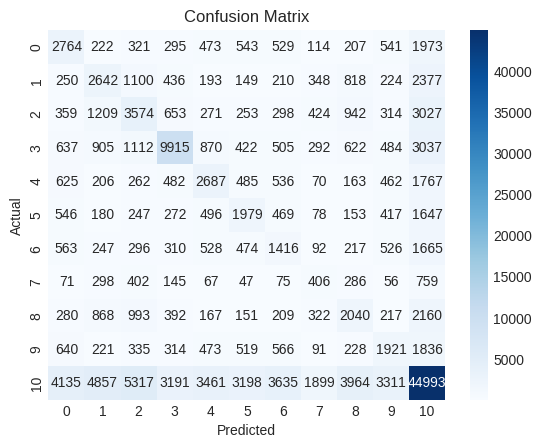

0.46558777721133754


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)